In [186]:
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
from scipy.sparse import csr_matrix, find, bmat, coo_matrix
import numpy as np
from sklearn.cluster import KMeans
import numpy as np
import random
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.utils import shuffle
from sklearn.metrics import calinski_harabaz_score

In [187]:
file = 'train.dat'
data = open(file, 'r')

In [188]:
docs = list()
for row in data:
    docs.append(row.rstrip().split(" "))    
print(len(docs))

8580


In [189]:
def csr_idf(mat, copy=False, **kargs):
    r""" Scale a CSR matrix by idf. 
    Returns scaling factors as dict. If copy is True, 
    returns scaled matrix and scaling factors.
    """
    if copy is True:
        mat = mat.copy()
    nrows = mat.shape[0]
    nnz = mat.nnz
    ind, val, ptr = mat.indices, mat.data, mat.indptr
    # document frequency
    df = defaultdict(int)
    for i in ind:
        df[i] += 1
    # inverse document frequency
    for k,v in df.items():
        df[k] = np.log(nrows / float(v))
    # scale by idf
    for i in range(0, nnz):
        val[i] *= df[ind[i]]
        
    return df if copy is False else mat

def csr_build(dataIndex, value, nnz, nrows):
    ind = np.zeros(nnz, dtype=np.int)
    val = np.zeros(nnz, dtype=np.double)
    ptr = np.zeros(nrows+1, dtype=np.int)
    i = 0
    n = 0
    
    for (d,v) in zip(dataIndex, value):
        l = len(d)
        for j in range(l):
            ind[int(j) + n] = d[j]
            val[int(j) + n] = v[j]
        
        ptr[i+1] = ptr[i] + l
        n += l
        i += 1
    
    mat = csr_matrix((val, ind, ptr), shape=(nrows, max(ind)+1), dtype=np.double)
    mat.sort_indices()
    
    return mat        

In [190]:
def getNormalizedCSR(docs):
    # sperate indices and values
    dataIndex = list()
    value = list()
    for d in docs:
        d_index = list()
        d_value = list()
        for i in range(0,len(d),2):      
            d_index.append(d[i])
        for j in range(1,len(d),2):     
            d_value.append(d[j])
        dataIndex.append(d_index)
        value.append(d_value)
        
    nrows = len(docs)

    idx = {}
    tid = 0
    nnz = 0
    ncol = 0
    _max = list()
    for d in dataIndex:
        nnz += len(d)
        _max.append(max(d))
        for w in d:
            if w not in idx:
#             print(w)
                idx[w] = tid
                tid += 1
    mat1 = csr_build(dataIndex, value, nnz, nrows)
    mat1 = csr_idf(mat1, copy=True)
    nrows = mat1.shape[0]
    nnz = mat1.nnz
    ind, val, ptr = mat1.indices, mat1.data, mat1.indptr
    # normalize
    for i in range(nrows):
        rsum = 0.0    
        for j in range(ptr[i], ptr[i+1]):
            rsum += val[j]**2
        if rsum == 0.0:
            continue  # do not normalize empty rows
        rsum = float(1.0/np.sqrt(rsum))
        for j in range(ptr[i], ptr[i+1]):
            val[j] *= rsum
    return mat1

In [191]:
mat3 = getNormalizedCSR(docs)

In [192]:
# from sklearn.metrics.pairwise import euclidean_distances
# A = coo_matrix(mat3)
# max = 0
# length = mat3.shape[0];
# for i in range(0,length/2):
#     for j in range(length/2,length):
#         distance = euclidean_distances(mat3[i], mat3[j])
#         if  distance > max:
#             max = distance
#             point1 = i
#             point2 = j

# print point1,"point1"
# print point2,"point2"
# print max

In [193]:
def calculate_sse(l1):
    su = 0
    A = coo_matrix(l1)
    mean = np.mean(A.data)
    for i,j,v in zip(A.row, A.col, A.data):
        su = su + ((mean - v)**2)
    return su

In [194]:
def initCentorids(x, k):
    x_shuffle = shuffle(x, n_samples=2)
    return x_shuffle

In [195]:
def sim(x1, x2):
    sims = x1.dot(x2.T)
    return sims

In [196]:
def findCentroids(matc, centroids):
    idx = list()
    simsMatrix = sim(matc, centroids)

    for i in range(simsMatrix.shape[0]):
        row = simsMatrix.getrow(i).toarray()[0].ravel()
        top_indices = row.argsort()[-1]
        idx.append(top_indices + 1)
    return idx

In [197]:
def computeMeans(matm, idx, k):
    centroids = list()
    for i in range(1,k+1):
        indi = [j for j, x in enumerate(idx) if x == i]
        members = matm[indi,:]
        if (members.shape[0] > 1):
            centroids.append(members.toarray().mean(0))
    centroids_csr = csr_matrix(centroids)
    return centroids_csr

In [198]:
m = [[]]
def divide(ids):
    global m
    c1 = list()
    c2 = list()
    if len(m[0]) == 0 :
        for j in range(len(ids)):
            if ids[j] == 1:
                c1.append(j)
            else :
                c2.append(j)
    else :
        for k in range(len(ids)):
            if ids[k] == 1:
                c1.append(m[0][k])
            else :
                c2.append(m[0][k])
    return c1, c2

In [199]:
def kmeans(k, matk, n_iter):
    i = 0
    centroids = initCentorids(matk, k)
    old_sse = []
    new_sse = [0]*2
    min_sse = 0.00001
    for _ in range(n_iter):
        idx = findCentroids(matk, centroids)
        clust1, clust2 = divide(idx)
        if i == 0:
            old_sse.append(calculate_sse(clust1))
            old_sse.append(calculate_sse(clust2))
            i = i+1;
        else :
            new_sse[0] = calculate_sse(clust1)
            new_sse[1] = calculate_sse(clust2)
            if (np.abs(old_sse[0]-new_sse[0]) <= min_sse) or (np.abs(old_sse[1]-new_sse[1]) <= min_sse) :
                return idx, clust1, clust2
            else :
                old_sse = new_sse[:]
        centroids = computeMeans(matk, idx, k)        
    return idx, clust1, clust2

In [200]:
from sklearn.metrics import calinski_harabaz_score
x_axis = list()
y_axis = list()
for k in range(3, 21, 2):
    idx, cc1, cc2 = kmeans(k, mat3, 40)
    score = calinski_harabaz_score(mat3.toarray(), idx)
    print k, score
    x_axis.append(k)
    y_axis.append(score)

3 68.8330924815
5 83.9848943512
7 84.0700871955
9 75.4795611374
11 83.6735570804
13 68.5004538835
15 84.0868027633
17 83.891575071
19 68.5130079591


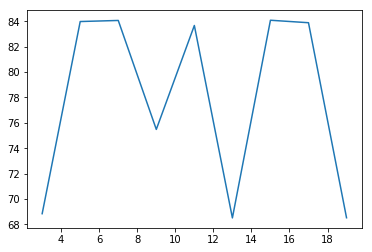

In [201]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(x_axis, y_axis)

In [202]:
def convert_to_csr(l1):
    mcsr = list()
    for i in l1:
        mcsr.append(docs[i])
    return a(mcsr)

In [203]:
unselected_clusters = set()
def choose_cluster(list_of_clusters):
    global unselected_clusters
    l2 = list()
    var =[]
    sse = []
    for i in list_of_clusters:
        unselected_clusters.add(tuple(i))
    greatest = 0

    for i in unselected_clusters:
        l2.append(convert_to_csr(i))
    for l in l2:
        sse.append(calculate_sse(l))

    csr_l2 = l2[(sse.index(max(sse)))]
    indx = list(unselected_clusters)[(sse.index(max(sse)))]
    unselected_clusters.remove(indx)
    return indx, csr_l2

In [204]:
temp = list()
def bisecting(matb):
    temp=matb.copy()
    global m
    for i in range(1, 7):
        ids, clust1, clust2 = kmeans(2, temp, 40)
        im, smat = choose_cluster([clust1, clust2])
        m = [im]
        temp = smat.copy()
    for i in m:
        unselected_clusters.add(tuple(i))
    return unselected_clusters
        

out = bisecting(mat3)

output_file = open("sse-kmeans+bisect-40-itr-0.401-1dec1.dat", "w");
z = 0
o = [0] * 8580
for x in out:
    z = z + 1
    for y in x:
        o[y] = z

for w in o:
    output_file.write(str(w))
    output_file.write('\n')
output_file.close()

'def printFile(outs):\n    output_file = open("output.dat", "w")\n    \nprintFile(out)'